### Assignment 2

Srinivas Kota  
2018101043  
Replicating results of Haxby 2001  

In [1]:
!mkdir -p data

In [2]:
### DOWNLOAD DATA
from nilearn import datasets

DATA_DIR = './data/'
haxby_dataset = datasets.fetch_haxby(data_dir=DATA_DIR, fetch_stimuli=True)

/data0/sai/haxby-2001/venv/lib64/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


#### Q1. What is the repetition time (TR) in seconds?

#### Ans.
Repetition Time (TR) = 2.5 seconds = 2500 ms

In [3]:
t_r = 2.5

#### Q2. How many brain volumes are acquired in time?

### Ans
There are 1452 brain volumes.

In [4]:
from nilearn import image

anatomical = image.load_img(img=haxby_dataset['anat'])
functional = image.load_img(img=haxby_dataset['func'])

voxels = functional.get_fdata()
print(f"Shape of voxels: {voxels.shape}")
print(f"Volumes: {voxels.shape[3]}")

Shape of voxels: (40, 64, 64, 1452)
Volumes: 1452


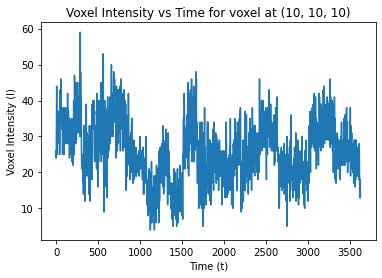

In [5]:
import matplotlib.pyplot as plt
import numpy as np

ind = 10
voxel_vs_t = voxels[ind][ind][ind]

plt.plot(np.array(range(len(voxel_vs_t))) * t_r, voxel_vs_t)
plt.xlabel("Time (t)")
plt.ylabel("Voxel Intensity (I)")
plt.title(f"Voxel Intensity vs Time for voxel at ({ind}, {ind}, {ind})")
plt.show()

#### Q3. What is the voxel resolution/dimension of the functional image? Is it isotropic or anisotropic?

#### Ans
The functional image is anisotropic. The dimension of the functional image is [3.5, 3.75, 3.75]. This is a cuboid, all sides of voxel are not the same.

In [6]:
# print(functional.header)
print(f"Pixel dimension: {functional.header['pixdim']}")

Pixel dimension: [1.   3.5  3.75 3.75 2.5  0.   0.   0.  ]


#### Q4. List out the categories that are used in the experiments for visual object recognition task? Plot one image from any of the two categories.

#### Ans
Labels:
 {'chair', 'bottle', 'scrambledpix', 'house', 'cat', 'shoe', 'scissors', 'face', 'rest'}

In [7]:
import pandas as pd

session = pd.read_csv(haxby_dataset['session_target'][0], ' ')

print(f"Shape of dataframe: {session.shape}")

Shape of dataframe: (1452, 2)


In [8]:
print(f"Categories in experiment for object recognition task:\n {set(session['labels'])}")

Categories in experiment for object recognition task:
 {'house', 'rest', 'bottle', 'scrambledpix', 'scissors', 'cat', 'face', 'shoe', 'chair'}


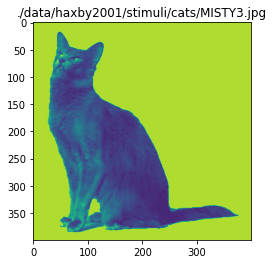

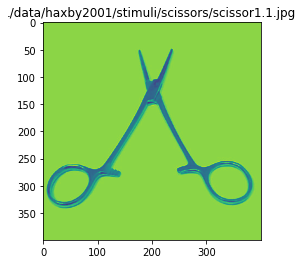

In [9]:
cat_image = haxby_dataset['stimuli']['cats'][0]
scissor_image = haxby_dataset['stimuli']['scissors'][0]

import matplotlib.image as pimg

def plot_image(path):
    plt.imshow(pimg.imread(path))
    plt.title(path)
    plt.show()


plot_image(cat_image)
plot_image(scissor_image)

#### Q5. For how many runs/sessions are the experiments repeated?

#### Ans
We have 12 unique runs of the experment


In [10]:
print(f"Sessions in experiemnt: {len(set(session['chunks']))}")

Sessions in experiemnt: 12


#### Masking, Plotting, analyse BOLD signal

In [11]:
from nilearn.input_data import NiftiMasker
def get_mask(nii):
    img = image.load_img(nii)
    mask = NiftiMasker(mask_img=img)
    return mask


/data0/sai/haxby-2001/venv/lib64/python3.6/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [12]:
mask_vt = get_mask(haxby_dataset['mask_vt'])
mask_house = get_mask(haxby_dataset['mask_house'])
mask_face = get_mask(haxby_dataset['mask_face'])

In [13]:
functional_vt = mask_vt.fit_transform(functional)
functional_house = mask_house.fit_transform(functional)
functional_face = mask_face.fit_transform(functional)


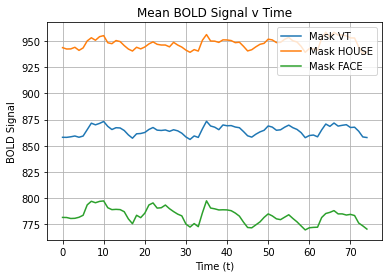

In [14]:
import numpy as np

def plot_bold_v_time(vt, face, house, time, title):
    plt.plot(np.mean(vt[:time], axis=1), label='Mask VT')
    plt.plot(np.mean(house[:time], axis=1), label='Mask HOUSE')
    plt.plot(np.mean(face[:time], axis=1), label='Mask FACE')
    plt.xlabel('Time (t)')
    plt.ylabel('BOLD Signal')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

time = 75
plot_bold_v_time(functional_vt, functional_face, functional_house, time, title="Mean BOLD Signal v Time")


The BOLD signal is noisy and has lot of variance. We smooth this signal.

In [15]:
highpass_filter = 0.008
standardize = True
detrend = True
smoothing_fwhm = 6

def get_smooth_mask(nii, t_r=2.5, high_pass=0.008, standardize=True, detrend=True, smoothing_fwhm=6):
    mask_img = image.load_img(img=nii)
    mask = NiftiMasker(mask_img=mask_img, t_r=t_r, high_pass=high_pass, standardize=standardize, detrend=detrend, smoothing_fwhm=smoothing_fwhm)
    return mask

smooth_mask_vt = get_smooth_mask(haxby_dataset['mask_vt'])
smooth_mask_face = get_smooth_mask(haxby_dataset['mask_face'])
smooth_mask_house = get_smooth_mask(haxby_dataset['mask_house'])

smooth_functional_vt = smooth_mask_vt.fit_transform(functional)
smooth_functional_face = smooth_mask_face.fit_transform(functional)
smooth_functional_house = smooth_mask_house.fit_transform(functional)



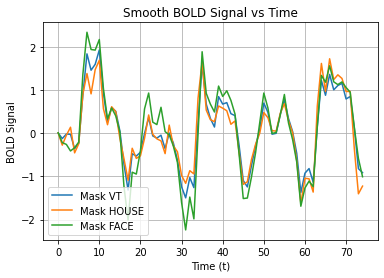

In [16]:
time = 75
plot_bold_v_time(smooth_functional_vt, smooth_functional_face, smooth_functional_house, time, title="Smooth BOLD Signal vs Time")



### Q6. After plotting the average signals from each of those masks (each 1D):
6.1 Does the signals appear like a block design or event related design?  
6.2 From the raw timeseries signals, can you see which stimulus evoked a larger response? Is it vt or face or house?

### Ans
6.1 The experiment has Block Design. We can see periodic activation and rest in the BLOCK signal vs time graph.  

6.2 Responses to the FACE seem to large in magnitude than response for HOUSE or VT in the observed time frame. 

#### Q7. What are the importance of high pass, standardize, detrend such parameters in fMRI time series analysis? Can you state their role? What could be influencing the results if such parameters are not specified?

#### Ans
##### High-Pass  
High Pass filter only lets higher frequencies pass through and blocks lower frequencies. The fMRI data obtained usually contains a lot of noise from the subjust such as breathing and from the machine such as vibraionts. This leads to the subject being unable to stay still across the scan leading to noisy data. We know that the hemodynamic response has frequency $>0.1 Hz$, therefore we can block all frequencies below this range using a HighPass filter  
  
##### Standardise  
Standardisation brings the amplitude of the of fMRI data to a single comparable range. While obtaining fMRI data, each voxel can give a different range of magnitudes. By applying standardisation we bring the magnitude of all voxels into a comparable range.  
  
##### Detrend  
Detrend converts the timeseries into a stationary timeseries by removing the linear trend in BOLD timesperies. This linear trend is observed as an increasing trend that can be caused by scanner instablility.

#### GLM with Nilearn

In [17]:
conditions = session['labels']
sessions = session['chunks']

session_number = 0

session_conditions = conditions[sessions == session_number]

n_scans = len(session_conditions)
frame_times = t_r * np.arange(n_scans)

duration = t_r * np.ones(n_scans)

events = pd.DataFrame(
    {
        'onset': frame_times,
        'trial_type': session_conditions,
        'duration': duration
    }
)

#### Q8. Observe the difference in the data array shape of conditions and conditions session? What does that mean? You can print the shapes of both arrays and tell us why they are different?

### Ans
Conditions has 1452 elements.  
Session Conditions has 121 elements.  
Conditions is universal set of conditions for all sessions. Session Conditions is a subset of this universal set we obtain by filtering for a given session. 

In [18]:
print(f"Shape of conditions: {conditions.shape}")
print(f"Shape of sessions conditions: {session_conditions.shape}")

Shape of conditions: (1452,)
Shape of sessions conditions: (121,)


In [19]:
from nilearn.glm.first_level import FirstLevelModel

highpass_filter = 0.008
smoothing_fwhm = 4
glm = FirstLevelModel(
    t_r=t_r,
    mask_img=haxby_dataset.mask,
    high_pass=highpass_filter,
    smoothing_fwhm=smoothing_fwhm
)

/data0/sai/haxby-2001/venv/lib64/python3.6/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


#### Q9. Why is smoothing necessary? What type of smoothing is implemented in the code?

#### Ans.
As we have discussed, fMRI data tends to have lot of noise due to human and environmental conditions during scan. By applying smoothing we aim to reduce the amount of noice and increase the signal to noise ratio. This is case due to the assumption that the noise in the sinal covers a smaller spatial region and therfore will even out faster than the main signal.  
  
Nilearn uses Gaussian Smoothing. The strenght of smoothing is defined by the `fwhm` value, i.e full width at half maximum and applying this value in each dimension.

In [20]:
z_maps = []
conditions_label = []
session_label = []

from nilearn.image import index_img

session_number = 1

fmri_session = index_img(functional, sessions == session_number)

glm.fit(fmri_session, events=events)

conditions = ['face', 'scrambledpix', 'scissors', 'shoe', 'bottle', 'cat', 'chair', 'house']

for condition_ in conditions:
    z_maps.append(glm.compute_contrast(condition_))
    conditions_label.append(condition_)
    session_label.append(session)

#### Q10. In the code, what is the role of nilearn.image.index img? Why is it important to apply on functional image?

#### Ans
`nilearn.image.index_img` extracts the frames in a given series of indexes. By applying it on the functional image and giving it a set of indexes we are picking only those images that are relavant to the session. Functional image has 1452 images, but session 1 has only 121 images. By using `index_img` we pick the images out of functional image that are relevant to us.

#### Q11. Dig into the FirstLevelModel and helps us understand what type of regression technique is used to estimate β maps? Which software is Nilearn dependent on for that regression technique?

#### Ans
FirstLevelModel is a multiple linear regression model. It used auto-regression to estimate the $\beta$ maps. It fits the BOLD timeseries data $Y$ to the regressors in the design matrix $X$. Nilearn used `numpy` to implement the regression technique.

#### Q12. Plot the design matrices attribute using nilearn.plotting.plot design matrix. What does each column represents? Does this makes sense with GLM design that is shown on Figure 2? Briefly elaborate how it made sense to you?

#### Ans.
Each column represents a regression. The regression variables we have are the experiment conditions, the motion variables and a constant.
This observation makes sense with the GLM design shown. The BOLD data $Y$ is fit using multiple regression on $X$.

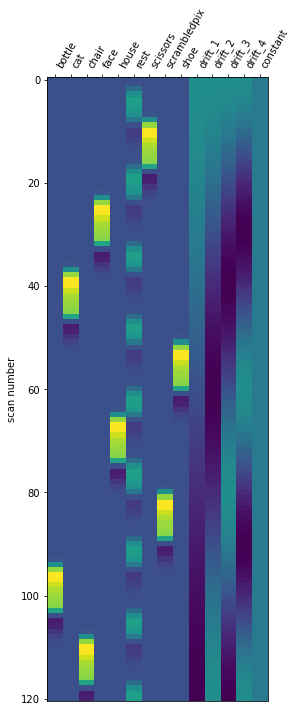

In [21]:
from nilearn import plotting

def plot_glm_design_matrix(dm):
    plotting.plot_design_matrix(dm)
    plotting.show()

plot_glm_design_matrix(glm.design_matrices_[0])

#### Q13. What is now the scanning length of fMRI per session?

#### Ans.
We have 121 frames for each session. Duration of each scan is `t_r = 2.5 seconds`.  
Total duration of scan = $302.5$ seconds

In [22]:
print(f"Duration of scan: {t_r * fmri_session.shape[-1]} seconds")

Duration of scan: 302.5 seconds


#### Q14. What is compute contrast? What it does? Plot the compute constrast outputs for all conditions using nilearn.plotting.plot stat map with bg img as Haxby data anatomical image. What is this output type z maps means?

#### Ans
##### Compute Contrast
Contrast map is the difference between the beta map (condition is active) and the rest map. Compute contrast calculates the constrast maps given a condition.

Contrast maps give us the regions that are active when the condition is active.

##### Z-maps
`z_maps` are constrast maps with the values standarised with variance 1.

In [23]:
def plot_contrast_map(conditions, z_maps, bg_img):
    for i, condition_ in enumerate(conditions):
        plotting.plot_stat_map(stat_map_img=z_maps[i], bg_img=bg_img, title=f"Condition: {condition_}")
    plotting.show()

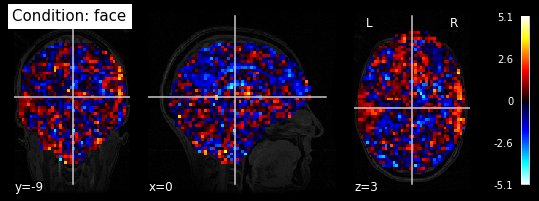

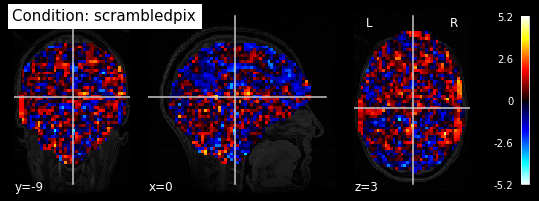

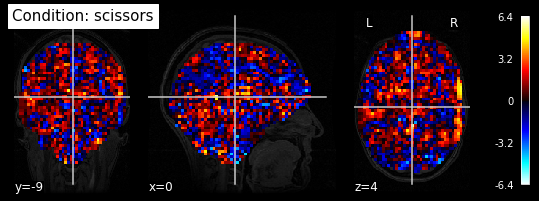

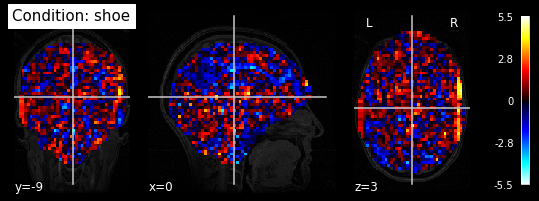

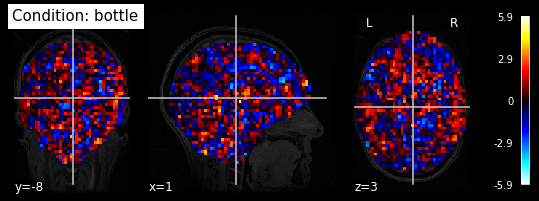

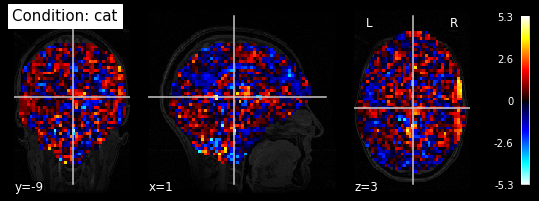

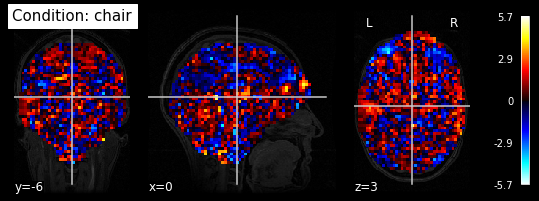

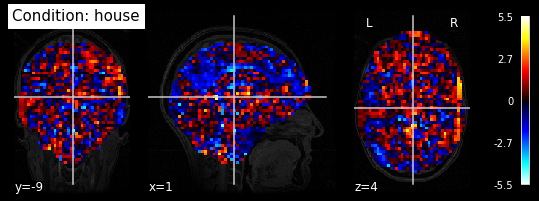

In [24]:
plot_contrast_map(conditions=conditions_label, z_maps=z_maps, bg_img=haxby_dataset['anat'][0])

#### GLM for all Sessions

In [25]:
from tqdm import tqdm 

mask_img = haxby_dataset['mask']
high_pass = 0.008
smoothing_fwhm = 4

z_maps = []
conditions_label = []
each_session_label = []

sessions = session['chunks']
conditions = session['labels']

for session_number in tqdm(set(sessions)):
    session_conditions = conditions[sessions == session_number]

    n_scans = len(session_conditions)

    frame_times = t_r * np.arange(n_scans)
    duration = t_r * np.ones(n_scans)

    events = pd.DataFrame({
        'onset': frame_times,
        'trial_type': session_conditions,
        'duration': duration
    })

    glm = FirstLevelModel(
        t_r=t_r,
        mask_img=mask_img,
        high_pass=high_pass,
        smoothing_fwhm=smoothing_fwhm
    )

    fmri_session = index_img(functional, sessions == session_number)

    glm.fit(fmri_session, events=events)

    set_conditions = set(conditions)
    for condition_ in set_conditions:
        z_maps.append(glm.compute_contrast(condition_))
        conditions_label.append(condition_)
        each_session_label.append(session_number)


100%|██████████| 12/12 [00:52<00:00,  4.34s/it]


#### Q15. Tell us what this example tried to replicate in the paper. Does the classification accuracies per ROI across different categories makes sense with the outcomes of the paper? Convince us by writing a brief paragraph to assess your understanding.

#### Ans
We try to replicate the HAXBY experiment by measuring accuracies using the VT, HOUSE and FACE masks. We observe that the accuracy for each mask are similar to those observed in the paper. We find that the Ventral Temporal (VT) mask outperforms the HOUSE and FACE mask. 

In [35]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

def evaluate_decoder_accuracy(mask_img, mask):
    decoder = Decoder(
        estimator='svc',
        cv=LeaveOneGroupOut(),
        mask=mask_img,
        standardize=False,
        screening_percentile=3,
    )

    decoder.fit(z_maps, conditions_label, groups=each_session_label)

    accuracy = np.mean(list(decoder.cv_scores_.values()))
    print(f"Classification Accuracy with mask {mask}: {accuracy*100}%")

import warnings
warnings.simplefilter('ignore', UserWarning)

evaluate_decoder_accuracy(mask_vt, mask='VT')
evaluate_decoder_accuracy(mask_house, mask='HOUSE')
evaluate_decoder_accuracy(mask_face, mask='FACE')


Classification Accuracy with mask VT: 89.12037037037037%
Classification Accuracy with mask HOUSE: 80.32407407407408%
Classification Accuracy with mask FACE: 76.9675925925926%
